In [1]:
# import modules
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from PIL import Image
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import json
import pandas as pd

In [2]:
image_folder = "/home/mingi/data/vistext/data/simple_images/vertical"
tsv_folder = "/home/mingi/data/vistext/data/test_tsv"
save_file = "/home/mingi/data/chartgemma/one_by_one_results/vertical.jsonl"

In [3]:
tsv = pd.read_csv(os.path.join(tsv_folder, "1509.tsv"), sep="\t")

--Return--
None
> /tmp/ipykernel_2639680/2469187751.py(17)<module>()
     15 
     16 import pdb
---> 17 pdb.set_trace()
     18 tsv_file = image_files[i].split('.')[0] + '.tsv'
     19 tsv = pd.read_csv(os.path.join(tsv_folder, tsv_file), sep="\t")

What is the value of 2020?
Answer the question using only number.

What is the value of 2019?
Answer the question using only number.

What is the value of 2018?
Answer the question using only number.

What is the value of 2017?
Answer the question using only number.

What is the value of 2016?
Answer the question using only number.

What is the value of 2015?
Answer the question using only number.

What is the value of 2014?
Answer the question using only number.

What is the value of 2013?
Answer the question using only number.

What is the value of 2012?
Answer the question using only number.

What is the value of 2011?
Answer the question using only number.

What is the value of 2010?
Answer the question using only number.



,Year,Net income in million U.S. dollars
0,2020,1931
1,2019,1809
2,2018,1533
3,2017,3021
4,2016,662
5,2015,1318
6,2014,992
7,2013,994
8,2012,1167
9,2011,1224


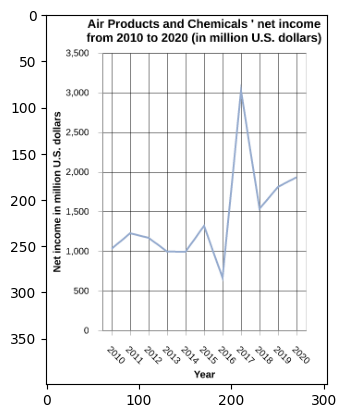

In [3]:
from pprint import pprint
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

i = 105

DIRECTION = "vertical"
tsv_folder = "/home/mingi/data/vistext/data/test_tsv"
image_folder = f"/home/mingi/data/vistext/data/simple_images/{DIRECTION}"

image_files = os.listdir(image_folder)
image = Image.open(os.path.join(image_folder, image_files[i])).convert("RGB")

tsv_file = image_files[i].split(".")[0] + ".tsv"
tsv = pd.read_csv(os.path.join(tsv_folder, tsv_file), sep="\t")

plt.imshow(image)
plt.plot()

for row in tsv.itertuples(index=False, name=None):
    row = list(row)
    question = f"What is the value of {row[0]}?\nAnswer the question using only number."
    print(question + "\n")
tsv

In [9]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_folder, tsv_folder, processor):
        self.image_folder = image_folder
        self.processor = processor
        self.tsv_folder = tsv_folder
        self.file_names = os.listdir(image_folder)

    def __getitem__(self, index):
        # prepare all questions for one file
        image_file = self.file_names[index]
        tsv_file = image_file.split(".")[0] + ".tsv"

        image = Image.open(os.path.join(self.image_folder, image_file)).convert("RGB")
        tsv = pd.read_csv(os.path.join(self.tsv_folder, tsv_file), sep="\t")

        question_list = []
        value_list = []
        for row in tsv.itertuples(index=False, name=None):
            row = list(row)
            question = f"What is the value of {row[0]}?\nAnswer the question using only number."
            question_list.append(question)
            value_list.append(row[1])

        inputs = []
        prompt_lengths = []
        for question in question_list:
            input = self.processor(text=question, images=image, return_tensors="pt")
            input = {k: v.to("cuda") for k, v in input.items()}
            inputs.append(input)

            prompt_length = input["input_ids"].shape[1]
            prompt_lengths.append(prompt_length)

        return inputs, prompt_lengths, image_file, value_list

    def __len__(self):
        return len(self.file_names)


def collate_fn(batch):
    inputs, prompt_lengths, image_file, value_list = zip(*batch)

    return inputs, prompt_lengths, image_file, value_list


def create_data_loader(
    image_folder,
    tsv_folder,
    processor,
    batch_size=1,
    # num_workers=4,
):
    assert batch_size == 1, "batch_size must be 1"
    dataset = CustomDataset(image_folder, tsv_folder, processor)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        # num_workers=num_workers,
        shuffle=False,
        collate_fn=collate_fn,
    )
    return data_loader

In [4]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    "ahmed-masry/chartgemma", torch_dtype=torch.float16
).cuda()
processor = AutoProcessor.from_pretrained("ahmed-masry/chartgemma")

os.makedirs(os.path.dirname(save_file), exist_ok=True)
ans_file = open(save_file, "w")

data_loader = create_data_loader(
    image_folder=image_folder, tsv_folder=tsv_folder, processor=processor
)

/home/mingi/anaconda3/envs/tinyllava_factory/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
for inputs, prompt_lengths, image_file, value_list in tqdm(
    data_loader, total=len(os.listdir(image_folder))
):
    inputs = inputs[0]
    image_file = image_file[0]
    prompt_lengths = prompt_lengths[0]
    value_list = value_list[0]

    output_text_list = []

    for input, prompt_length in zip(inputs, prompt_lengths):
        with torch.inference_mode():
            generate_ids = model.generate(**input, num_beams=4, max_new_tokens=512)

        output_text = processor.batch_decode(
            generate_ids[:, prompt_length:],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )[0]
        output_text_list.append(output_text)

        # print(output_text)

    ans_file.write(
        json.dumps(
            {
                "image_file": image_file,
                "text": output_text_list,
                "value_list": value_list,
            }
        )
        + "\n"
    )
ans_file.close()

100%|██████████| 373/373 [1:42:56<00:00, 16.56s/it]  
